In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa

In [2]:
%load_ext sparksql_magic
%lsmagic
%config SparkSql.max_num_rows=9

In [3]:
%%html
<style>table {float:left}</style>

In [4]:
from pandas import DataFrame
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
df = spark.sql("select 'spark' as hello ")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [5]:
parquetFilepath = 'E:\work\canecrushers\i512by512\image_values_7680_10240_2019-08-09.snappy.parquet'
#filepath = 'E:\work\canecrushers\i32by32'

imgData = spark.read.parquet(parquetFilepath)

imgData.createOrReplaceTempView("image")
imgData.printSchema

<bound method DataFrame.printSchema of DataFrame[tile_x: bigint, tile_y: bigint, x: bigint, y: bigint, date: string, mask: bigint, red: bigint, green: bigint, blue: bigint, B01: bigint, B02: bigint, B03: bigint, B04: bigint, B05: bigint, B06: bigint, B07: bigint, B08: bigint, B09: bigint, B10: bigint, B11: bigint, B12: bigint, clouds: boolean, havested: boolean, NDVI: bigint, GNDVI: bigint, RDVI: bigint, RBNDVI: bigint, LCI: bigint, LAI: bigint, GLI: bigint, SCI: bigint]>

In [6]:
%%sparksql
select count(1) row_count from image

row_count
262144


In [7]:
%%sparksql
select * from image
limit 9

tile_x,tile_y,x,y,date,mask,red,green,blue,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,B12,clouds,havested,NDVI,GNDVI,RDVI,RBNDVI,LCI,LAI,GLI,SCI
7680,10240,0,0,2019-08-09,0,56,62,69,2548,1910,1712,1534,2234,3812,0,4202,1566,26,4552,2520,False,False,4651,4210,704549,4186,30,1857,1857,399
7680,10240,0,1,2019-08-09,0,55,64,71,2548,1964,1768,1524,2234,3812,0,4456,1566,26,4552,2520,False,False,4903,4318,758304,4374,33,1889,1889,106
7680,10240,0,2,2019-08-09,0,58,64,73,2332,2006,1768,1596,2290,3746,0,4418,1406,20,4588,2666,False,False,4692,4283,727788,4208,31,1785,1785,188
7680,10240,0,3,2019-08-09,3,63,65,72,2332,1986,1782,1738,2290,3746,0,4402,1406,20,4588,2666,False,False,4338,4236,679954,4054,31,1370,1370,206
7680,10240,0,4,2019-08-09,4,67,69,74,2332,2046,1902,1840,2462,3702,0,4524,1406,20,4896,3100,False,False,4217,4080,672895,3991,29,1445,1445,394
7680,10240,0,5,2019-08-09,6,67,69,73,2332,2010,1894,1850,2462,3702,0,4334,1406,20,4896,3100,False,False,4016,3917,631752,3837,27,1419,1419,608
7680,10240,0,6,2019-08-09,0,61,68,72,2332,1986,1872,1692,2328,3546,0,4150,1406,20,4686,2786,False,False,4207,3782,643177,3858,28,1582,1582,606
7680,10240,0,7,2019-08-09,0,61,68,72,2332,1990,1872,1680,2328,3546,0,4244,1406,20,4686,2786,False,False,4328,3878,666255,3962,29,1616,1616,494
7680,10240,0,8,2019-08-09,0,64,70,73,2394,2026,1920,1750,2188,3732,0,4308,1412,22,4470,2464,False,False,4222,3834,657303,3905,32,1112,1112,184


|abr|index name|expression|
|:--|:---------|:---------|
|NDVI|Normalised Difference Vegetation Index (NDVI)|= (NIR - RED) / (NIR + RED)|
|GNDVI|Green Normalized Difference|= (NIR - GREEN)/(NIR + GREEN)|
|RBNDVI|Red Blue Normalised Difference Vegetation Index (NDVI)|= (2*NIR - RED -BLUE) / (2*NIR + RED + BLUE)|
|LCI|Leaf Chlorophyll Index|= (NIR - REDE)/(NIR + REDE)|
|LAI|Leaf Area Index|= (REDE - RED)/(REDE + RED)|
|NDMI|Normalized Difference Moisture Index|= (NIR - SWIR)/(SWIR + NIR)|


In [8]:
%%sparksql -c -v vegi1 vegi1DF

with min_max as (
    select min(B08)  min_NIR
         , min(B04)  min_RED
         , min(B03)  min_GRN
         , max(B08)  max_NIR
         , max(B04)  max_RED
         , max(B03)  max_GRN
    from image
), normalised as (
    select x, y
        , 1.0 * (i.B08 - m.min_NIR) / (m.max_NIR - m.min_NIR) as NIR
        , 1.0 * (i.B04 - m.min_RED) / (m.max_RED - m.min_RED) as RED
        , 1.0 * (i.B03 - m.min_GRN) / (m.max_GRN - m.min_GRN) as GRN
    from image i 
    cross join min_max m
    where i.mask = 0
)
select x,y, NIR, RED, GRN
from normalised

cache dataframe with lazy load
create temporary view `vegi1`
capture dataframe to local variable `vegi1DF`
only showing top 9 row(s)


x,y,NIR,RED,GRN
0,0,0.4287338031370766,0.1480942682572010,0.1321512211441954
0,1,0.4576040009092976,0.1466395112016293,0.1415189026430244
0,2,0.4532848374630598,0.1571137620017457,0.1415189026430244
0,6,0.4228233689474881,0.1710794297352342,0.1589160254265641
0,7,0.4335076153671289,0.1693337212685482,0.1589160254265641
0,8,0.4407819959081609,0.1795170206575502,0.1669454667112747
0,12,0.4439645373948625,0.2025021821355834,0.1656072264971562
0,13,0.4335076153671289,0.2091940645912133,0.1669454667112747
0,14,0.4128210957035690,0.2112307244690137,0.1896955503512881


In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [10]:
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
vegi1FeaturedDF = VectorAssembler(inputCols=['NIR','RED','GRN'], outputCol="features").transform(vegi1DF)
vegi1ClusteredDF =  kmeans.fit(vegi1FeaturedDF.select('features')).transform(vegi1FeaturedDF)

In [11]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
#import plotly.graph_objects as go

In [12]:
def sparkDFtoPandasPlusOne(spark_df, columns, n=100):
    result = spark_df.select(*columns).toPandas().sample(n)
    result['one']=1
    return result

vegi1Scatter_pd = sparkDFtoPandasPlusOne(vegi1ClusteredDF, ['RED','GRN','NIR','prediction'])

In [16]:
fig = px.scatter_3d(vegi1Scatter_pd, x='RED', y='GRN', z='NIR', color='prediction').show() #,size='one',size_max=5).show()
#fig.update_traces(marker=dict(size=5, line=dict(width=0, color='DarkSlateGrey')))
#fig.show()

In [17]:
from PIL import Image, ImageDraw
def open_image(path, mode = None, cropbox = None, verbose = True):
    if verbose:
        print(path)
    img = Image.open(path)
    if cropbox is not None:
        img = img.crop(cropbox)
    if mode is not None:
        img = img.convert(mode)
    if verbose:
        print("Format: {0}\nSize: {1}\nMode: {2}".format(img.format, img.size, img.mode))
        (width, height) = img.size
        print('width:',width,'height:',height)
    return img

In [35]:
maskFilePath = 'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\masks\\sugarcane-region-mask.png'
mask = open_image(maskFilePath, mode='RGB')

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\masks\sugarcane-region-mask.png
Format: None
Size: (512, 512)
Mode: P
width: 512 height: 512


In [18]:
tciFilePath = 'E:\\work\\canecrushers\\phase-01\\data\\sentinel-2a-tile-7680x-10240y\\timeseries\\7680-10240-TCI-2019-08-09.png'
tci = open_image(tciFilePath, mode='RGB')

E:\work\canecrushers\phase-01\data\sentinel-2a-tile-7680x-10240y\timeseries\7680-10240-TCI-2019-08-09.png
Format: PNG
Size: (512, 512)
Mode: RGB
width: 512 height: 512


In [23]:
vegiClustered_df = vegi1ClusteredDF.select('x','y','prediction').toPandas()
vegiClustered_df.head(5)

,x,y,prediction
0,0,0,0
1,0,1,0
2,0,2,0
3,0,6,0
4,0,7,0


In [22]:
imgnp = np.array(tci)
imgnp[0,0]

array([56, 62, 69], dtype=uint8)

In [31]:
# overlay harvest predition onto image
green_np = np.array([0,255,0], dtype='uint8')
red_np = np.array([255,0,0], dtype='uint8')
for row in vegiClustered_df.itertuples():
    if row.prediction == 0:
        imgnp[row.y,row.x] = green_np
    else:
        imgnp[row.y,row.x] = red_np

In [44]:
np.array(mask)[0,0]

0

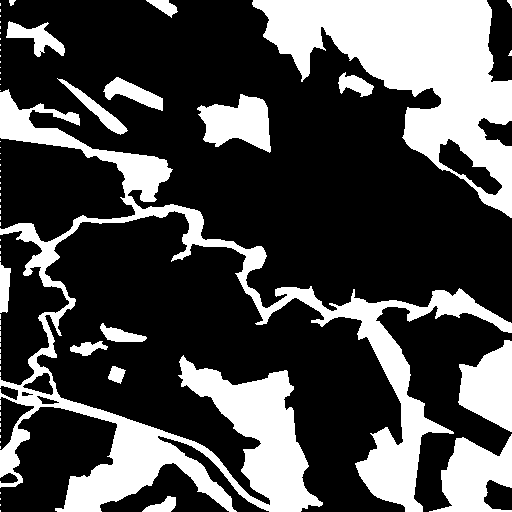

In [43]:
mask

In [41]:
# overlay mask image
mask_overlay_np = np.array(tci)
masknp = np.array(mask)
(width, height) = mask.size
for x in range(0,width):
    for y in range(0,height):
        if masknp[x,y].all(0):
            mask_overlay_np[x,y] = masknp[x,y]

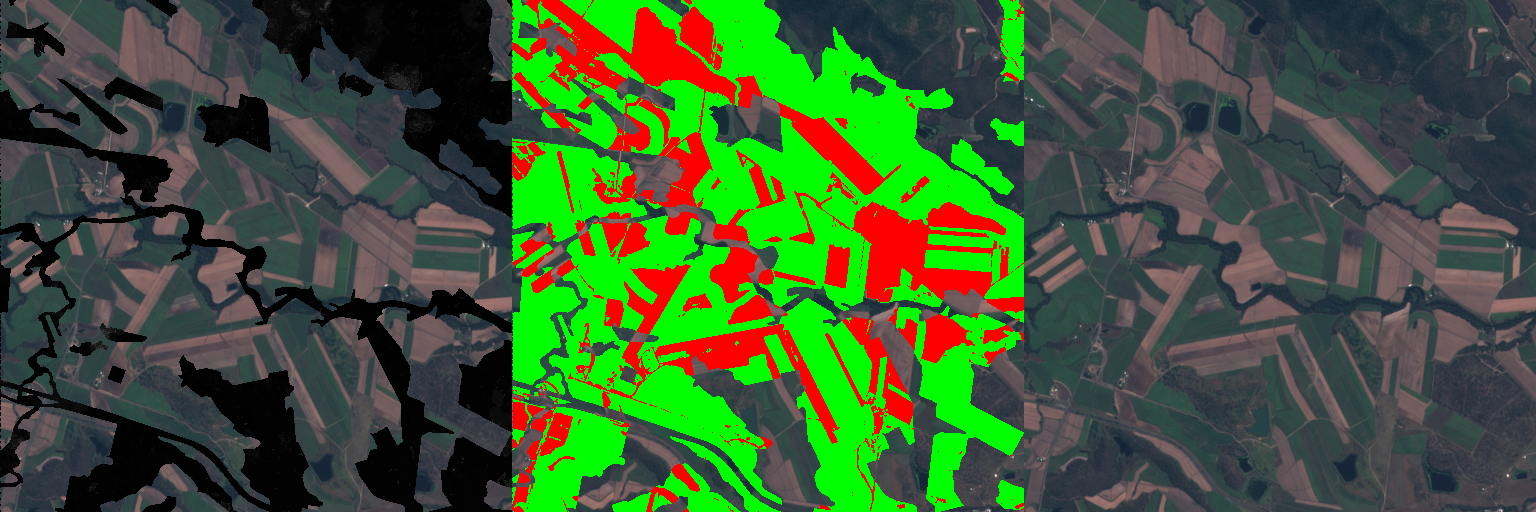

In [42]:
Image.fromarray(np.hstack((mask_overlay_np,imgnp,np.array(tci))))

In [ ]:
%%sparksql -c -v vegi2 veg2iDF

with min_max as (
    select min(NDVI)  min_NDVI
         , min(RBNDVI)  min_RBNDVI
         , min(LAI)  min_LAI
         , max(NDVI)  max_NDVI
         , max(RBNDVI)  max_RBNDVI
         , max(LAI)  max_LAI
    from image
), normalised as (
    select x, y
        , 1.0 * (i.NDVI - m.min_NDVI) / (m.max_NDVI - m.min_NDVI) as NDV
        , 1.0 * (i.RBNDVI - m.min_RBNDVI) / (m.max_RBNDVI - m.min_RBNDVI) as RBI
        , 1.0 * (i.LAI - m.min_LAI) / (m.max_LAI - m.min_LAI) as LAI
    from image i 
    cross join min_max m
    where i.mask = 0
)
select x,y, NDV, RBI, LAI
from normalised

In [ ]:
vegi2FeaturedDF = VectorAssembler(inputCols=['NDV','RBI','LAI'], outputCol="features").transform(veg2iDF)
vegi2FeaturedDF.toPandas().head(5)

In [ ]:
# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
vegi2ClusteredDF =  kmeans.fit(vegi2FeaturedDF.select('features')).transform(vegi2FeaturedDF)
vegi2ClusteredDF.select('x','y','prediction').toPandas().head(5)

In [ ]:
fig = px.scatter_3d(clusteredDF.select('NDV','RBI','LAI','prediction').toPandas(), x='NDV', y='RBI', z='LAI',color='prediction').show()